# Compare Valik prefiltering to Stellar ground truth

In [24]:
import matplotlib.pyplot as plt

SMALL_SIZE = 15
MEDIUM_SIZE = 17
BIGGER_SIZE = 20

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize

plt.rcParams["figure.figsize"] = (9,6)

## Experiment setup

Simulated two sequence experiments:
- both 83^6 bytes in size 
- read length 150
- reads sampled with 0.05 error rate
- 64 bins
    - 10Mb reference genome or 80Mb reference genome
    - 512 or 64 total genomes

Local search strategies:
- minLen 50
- max error rate: 0.025 or 1 error
- (15, 13)-minimisers
- overlap (1-49)

In [25]:
#---------- INPUT ----------
sim_er = 0.05
search_er = 0.025
o = 49
size = "10M"

bins = 64
bin_list = list(range(bins))
bin_list = [str(bin).zfill(len(str(bins))) for bin in bin_list]

In [38]:
import pandas as pd
import numpy as np

# input: path to stellar output
# output: df where instead of specific sequences reads are mapped to a bin
def get_stellar_bin_df(stellar_path):
    stellar_bin_df = pd.read_csv(stellar_path, sep=" ", header=None)
    stellar_bin_df.columns = ["Stellar-BIN", "QID"]
    stellar_bin_df["Stellar-BIN"] = pd.to_numeric(stellar_bin_df["Stellar-BIN"].str.split("_").str[1])
    stellar_bin_df = stellar_bin_df[["QID", "Stellar-BIN"]].drop_duplicates()
    return stellar_bin_df

def get_stellar_df(workdir):
    frames = []
    for b in bin_list:
        stellar_path = stellar_path = "../" + workdir + "/matches/bin_" + b + "_e" + str(sim_er) + ".txt"
        stellar_bin_df = get_stellar_bin_df(stellar_path)
        frames.append(stellar_bin_df)

    stellar_df = pd.concat(frames, ignore_index = True)
    stellar_df = stellar_df.drop_duplicates()
    return stellar_df

def get_valik_df(valik_path):
    valik_df = pd.read_csv(valik_path, sep="\t", header=None)
    valik_df.columns = ["QID", "matches"]
    valik_df = valik_df.assign(match_cols=valik_df['matches'].str.split(',')).explode('matches')
    valik_df = valik_df.drop(["matches"], axis = 1)
    valik_df = valik_df.explode("match_cols")
    valik_df.columns = ["QID", "Valik-BIN"]
    valik_df = valik_df.replace(r'^\s*$', np.nan, regex=True).dropna() # drop empty rows
    valik_df = valik_df.reset_index(drop = True)
    valik_df["Valik-BIN"] = pd.to_numeric(valik_df["Valik-BIN"])
    return valik_df

## Prefiltering performance depending on IBF size

In [31]:
size_workdirs = ["size_1_haplotype", "size_8_haplotypes"]

size_list = ["1M", "5M", "10M", "15M", "20M", "25M", "30M", "35M", "40M", "45M", "50M", "55M", "60M"]

In [103]:
import os.path
for workdir in size_workdirs:
    stellar_df = get_stellar_df(workdir)
    with open('../' + workdir + '/search_accuracy.tsv', 'a') as f:
        f.write("IBF-size\tTP\tFP\tFN\tPrecision\tRecall\n")
        for size in size_list:
            valik_path = "../out/" + size + "/e" + str(sim_er) + "_o" + str(o) + ".out"
            valik_df = get_valik_df(valik_path)
        
            TP_df = pd.merge(valik_df, stellar_df,  how='inner', left_on=["QID","Valik-BIN"], right_on = ["QID","Stellar-BIN"])
            TP = len(TP_df["QID"])
        
            # number of unnecessary bins that need to be searched
            FP = len(valik_df["QID"]) - TP
        
            # number of bin matches that can not be found after prefiltering
            FN = len(stellar_df["QID"]) - TP
        
            precision = TP / (TP + FP)
        
            recall = TP / (TP + FN)
        
            f.write(size + "\t" + str(TP) + "\t" + str(FP) + "\t" + str(FN) + "\t" + str(precision) 
                    + "\t" + str(recall) + "\n")

            print("Finished processing {}".format(size))
    f.close()

Finished processing 1M
Finished processing 5M
Finished processing 10M
Finished processing 15M
Finished processing 20M
Finished processing 25M
Finished processing 30M
Finished processing 35M
Finished processing 40M
Finished processing 45M
Finished processing 50M
Finished processing 55M
Finished processing 60M


### Plotting IBF size

In [32]:
res8 = pd.read_csv("../" + size_workdirs[1] + "/search_accuracy.tsv", sep="\t")
res8

,IBF-size,TP,FP,FN,Precision,Recall
0,1M,460550,29446302,8,0.015399,0.999983
1,5M,459076,46093,1482,0.908757,0.996782
2,10M,458693,44065,1865,0.912353,0.995951
3,15M,458598,43629,1960,0.913129,0.995744
4,20M,458558,43515,2000,0.913329,0.995657
5,25M,458531,43408,2027,0.913519,0.995599
6,30M,458524,43380,2034,0.913569,0.995584
7,35M,458512,43348,2046,0.913625,0.995558
8,40M,458512,43323,2046,0.913671,0.995558
9,45M,458507,43317,2051,0.913681,0.995547


In [33]:
res1 = pd.read_csv("../" + size_workdirs[0] + "/search_accuracy.tsv", sep="\t")
res1

,IBF-size,TP,FP,FN,Precision,Recall
0,1M,460555,32307381,1,0.014055,0.999998
1,5M,460555,32307202,1,0.014055,0.999998
2,10M,460527,19187650,29,0.023439,0.999937
3,15M,460309,2603779,247,0.150227,0.999464
4,20M,460054,426686,502,0.518815,0.998910
5,25M,459829,132159,727,0.776754,0.998421
6,30M,459621,74240,935,0.860938,0.997970
7,35M,459495,58113,1061,0.887728,0.997696
8,40M,459376,52420,1180,0.897576,0.997438
9,45M,459319,49802,1237,0.902180,0.997314


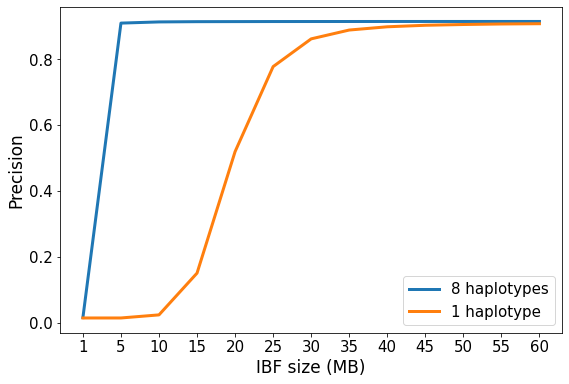

In [34]:
X = [s.replace("M", "") for s in size_list]

h8 = res8["Precision"]
h1 = res1["Precision"]
plt.plot(X, h8, label = "8 haplotypes", linewidth=3)
plt.plot(X, h1, label = "1 haplotype", linewidth=3)

#plt.title('The effect of IBF size on filtering accuracy', size = 20)
plt.xlabel('IBF size (MB)')
plt.ylabel('Precision')
plt.legend()
#plt.xlim([0.01, 0.07])
plt.savefig("../IBF_size.png", dpi = 140)
plt.show()

## Prefiltering preformance depending on overlap

In [40]:
import numpy as np

read_len = 150
pattern_size = 50
workdir = "overlap"
overlap_list = [0, 10, 20, 30, 40, 45, 46, 47, 48, 49]
stellar_df = get_stellar_df(workdir)


runtime_list = []
pattern_count_list = []
for overlap in overlap_list:
    # find number of patterns
    pattern_begin_positions = []
    for i in range(0, read_len - pattern_size + 1, pattern_size - overlap):
        pattern_begin_positions.append(i)
        last_begin = i

    if (last_begin < read_len - pattern_size):
        # last pattern might have a smaller overlap to make sure the end of the read is covered
        pattern_begin_positions.append(read_len - pattern_size)
    
    pattern_count_list.append(len(pattern_begin_positions))
    
    # gather run-time
    time_file = "../" + workdir + "/" + str(overlap) + "_valik.time"
    time = pd.read_csv(time_file, sep="\t", header=None)
    avg_runtime = round(np.mean(time[0]), 2)
    runtime_list.append(avg_runtime)

print(runtime_list)
print(pattern_count_list)

[65.0, 64.81, 64.96, 65.29, 67.05, 70.39, 72.12, 75.53, 81.22, 93.12]
[3, 4, 5, 6, 11, 21, 26, 35, 51, 101]


In [41]:
import os.path

with open('../' + workdir + '/search_accuracy.tsv', 'a') as f:
    f.write("overlap\t#patterns\tTP\tFP\tFN\tPrecision\tRecall\tRuntime(sec)\n")
    for i in range(len(overlap_list)):
        overlap = overlap_list[i]
        runtime = runtime_list[i]
        pattern_count = pattern_count_list[i]
        
        valik_path = "../" + workdir + "/" + size + "/e" + str(sim_er) + "_o" + str(overlap) + ".out"
        valik_df = get_valik_df(valik_path)
        
        TP_df = pd.merge(valik_df, stellar_df,  how='inner', left_on=["QID","Valik-BIN"], right_on = ["QID","Stellar-BIN"])
        TP = len(TP_df["QID"])
        
        # number of unnecessary bins that need to be searched
        FP = len(valik_df["QID"]) - TP
        
        # number of bin matches that can not be found after prefiltering
        FN = len(stellar_df["QID"]) - TP
        
        precision = TP / (TP + FP)
        
        recall = TP / (TP + FN)
        
        f.write(str(overlap) + "\t" + str(pattern_count) + "\t" + str(TP) + "\t" + str(FP) + "\t" + str(FN) + "\t" + str(precision) 
                + "\t" + str(recall) + "\t" + str(runtime) + "\n")

        print("Finished processing {}".format(overlap))
f.close()

Finished processing 0
Finished processing 10
Finished processing 20
Finished processing 30
Finished processing 40
Finished processing 45
Finished processing 46
Finished processing 47
Finished processing 48
Finished processing 49


In [43]:
import pandas as pd
res = pd.read_csv("../" + workdir + "/search_accuracy.tsv", sep="\t")
res

,overlap,#patterns,TP,FP,FN,Precision,Recall,Runtime(sec)
0,0,3,367885,26936,92673,0.931777,0.798781,65.00
1,10,4,404227,29531,56331,0.931918,0.877690,64.81
2,20,5,421084,31531,39474,0.930336,0.914291,64.96
3,30,6,434832,33680,25726,0.928113,0.944142,65.29
4,40,11,449507,37674,11051,0.922669,0.976005,67.05
5,45,21,455080,40597,5478,0.918098,0.988106,70.39
6,46,26,455897,41192,4661,0.917134,0.989880,72.12
7,47,35,456972,41978,3586,0.915867,0.992214,75.53
8,48,51,457922,43055,2636,0.914058,0.994277,81.22
9,49,101,458693,44065,1865,0.912353,0.995951,93.12


In [6]:
# FNR
list(round(res["FN"] / (res["FP"] + res["TP"]), 3))

[0.235, 0.13, 0.087, 0.055, 0.023, 0.011, 0.009, 0.007, 0.005, 0.004]

In [14]:
list(res["Runtime(sec)"])

[65.0, 64.81, 64.96, 65.29, 67.05, 70.39, 72.12, 75.53, 81.22, 93.12]

In [17]:
list(round(res["Recall"], 3))

[0.799, 0.878, 0.914, 0.944, 0.976, 0.988, 0.99, 0.992, 0.994, 0.996]

### Plotting overlap length

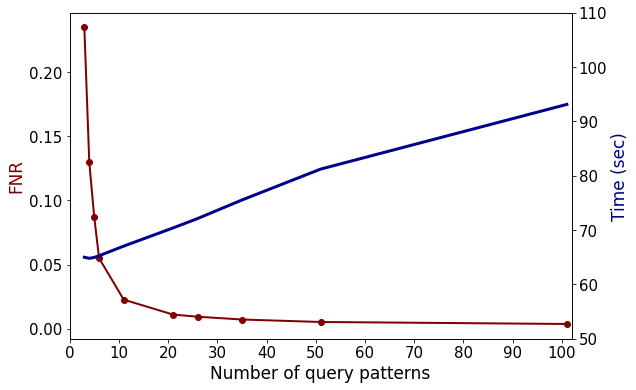

In [44]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import gridspec

X = res["#patterns"]
rt = res["Runtime(sec)"]
pr = res["Precision"]
re = res["Recall"]
fnr = res["FN"]/(res["FP"]+res["TP"])

# create figure and axis objects with subplots()
fig,ax = plt.subplots()
# make a plot
# ax.plot(X, pr, color="red")
ax.plot(X, fnr, color="maroon", marker="o", linewidth=2)
# set x-axis label
ax.set_xlabel("Number of query patterns")
# set y-axis label
ax.set_ylabel("FNR",color="maroon")

#twin object for two different y-axis on the sample plot
ax2=ax.twinx()
# make a plot with different y-axis using second axis object
ax2.plot(X, rt,color="darkblue", linewidth=3)
ax2.set_ylabel("Time (sec)",color="darkblue")
ax2.xaxis.set_ticks(np.arange(0, 101, 10))
plt.ylim(50, 110)
plt.xlim(0, 102)
plt.show()
fig.savefig("../Pattern_count_time.png", dpi = 140)